In [ ]:
Loading of the dataframe

In [6]:
import pandas as pd

try:
    # Replace '/kaggle/input/your-dataset-name/crop_details.csv' with the ACTUAL path
    df = pd.read_csv('/kaggle/input/crop-system/Crop_details.csv')
    print("DataFrame loaded successfully!")
except FileNotFoundError:
    print("Error: crop_details.csv not found. Please check the file path in the Kaggle Data tab.")
except Exception as e:
    print(f"An error occurred: {e}")

# Now, display the first few rows to confirm loading
if 'df' in locals():
    print(df.head())

DataFrame loaded successfully!
   Unnamed: 0                                               path       crop  \
0           0  /kaggle/input/kag2/sugarcane/sugarcane037ahs.jpeg  sugarcane   
1           1    /kaggle/input/kag2/sugarcane/sugarcane034a.jpeg  sugarcane   
2           2  /kaggle/input/kag2/sugarcane/sugarcane032arot....  sugarcane   
3           3  /kaggle/input/kag2/sugarcane/sugarcane036ahs.jpeg  sugarcane   
4           4  /kaggle/input/kag2/sugarcane/sugarcane023ahs.jpeg  sugarcane   

   croplabel  
0          3  
1          3  
2          3  
3          3  
4          3  


Display of the data

In [7]:
# Display the first few rows of the relevant columns
print(df[['path', 'crop', 'croplabel']].head())

                                                path       crop  croplabel
0  /kaggle/input/kag2/sugarcane/sugarcane037ahs.jpeg  sugarcane          3
1    /kaggle/input/kag2/sugarcane/sugarcane034a.jpeg  sugarcane          3
2  /kaggle/input/kag2/sugarcane/sugarcane032arot....  sugarcane          3
3  /kaggle/input/kag2/sugarcane/sugarcane036ahs.jpeg  sugarcane          3
4  /kaggle/input/kag2/sugarcane/sugarcane023ahs.jpeg  sugarcane          3


Display of image to check if the path is correct

Attempting to load image from: /kaggle/input/crop-system/kag2/sugarcane/sugarcane037ahs.jpeg
Image found at: /kaggle/input/crop-system/kag2/sugarcane/sugarcane037ahs.jpeg


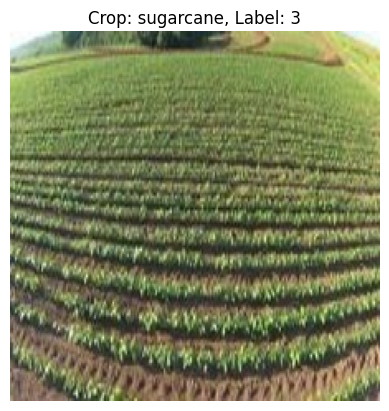

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Construct the correct base path
base_path = '/kaggle/input/crop-system/kag2'

# Get the path of the first image from the DataFrame and adjust it
relative_path = df['path'].iloc[0]
first_image_path = os.path.join(base_path, relative_path.split('/')[-2], relative_path.split('/')[-1]) # Adjusting to join correctly
print(f"Attempting to load image from: {first_image_path}")

try:
    # Check if the file exists
    if os.path.exists(first_image_path):
        print(f"Image found at: {first_image_path}")
        img = Image.open(first_image_path)
        plt.imshow(img)
        plt.title(f"Crop: {df['crop'].iloc[0]}, Label: {df['croplabel'].iloc[0]}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Error: Image not found at the specified path: {first_image_path}")

except FileNotFoundError:
    print(f"Error: Image file not found: {first_image_path}")
except Exception as e:
    print(f"An error occurred while loading the image: {e}")

Load of few images as

In [17]:
import numpy as np
from tqdm.notebook import tqdm # For progress bar
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Set image size
img_width, img_height = 128, 128
num_classes = df['croplabel'].nunique()
base_path = '/kaggle/input/crop-system/kag2'
image_paths = df['path'].tolist()
labels = df['croplabel'].astype('int').tolist() # Convert labels to integers

def load_and_preprocess_image(image_path, base_path, img_width, img_height):
    full_path = os.path.join(base_path, image_path.split('/')[-2], image_path.split('/')[-1])
    try:
        img = load_img(full_path, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        img_array = img_array / 255.0 # Normalize pixel values
        return img_array
    except Exception as e:
        print(f"Error loading image: {full_path} - {e}")
        return None

# Load and preprocess a subset of images (e.g., the first 100)
num_samples = 100
X = []
y = []

for i in tqdm(range(num_samples)):
    img_array = load_and_preprocess_image(image_paths[i], base_path, img_width, img_height)
    if img_array is not None:
        X.append(img_array)
        y.append(labels[i])

X = np.array(X)
y = np.array(y)

print("Shape of X (image data):", X.shape)
print("Shape of y (labels):", y.shape)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

2025-05-03 10:42:05.416878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746268925.633171      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746268925.704557      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  0%|          | 0/100 [00:00<?, ?it/s]

Shape of X (image data): (100, 128, 128, 3)
Shape of y (labels): (100,)
Shape of X_train: (80, 128, 128, 3)
Shape of X_val: (20, 128, 128, 3)
Shape of y_train: (80,)
Shape of y_val: (20,)


CNN model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax') # Output layer with softmax for multi-class classification
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Suitable for integer labels
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-03 10:45:21.526256: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

train our model using epochs

In [19]:
epochs = 10
batch_size = 32

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 522ms/step - accuracy: 0.4250 - loss: 0.9362 - val_accuracy: 1.0000 - val_loss: 2.1040e-06
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step - accuracy: 1.0000 - loss: 8.3540e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step - accuracy: 1.00

now loading all data

In [20]:
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Set image size
img_width, img_height = 128, 128
num_classes = df['croplabel'].nunique()
base_path = '/kaggle/input/crop-system/kag2'
image_paths = df['path'].tolist()
labels = df['croplabel'].astype('int').tolist()

def load_and_preprocess_image(image_path, base_path, img_width, img_height):
    full_path = os.path.join(base_path, image_path.split('/')[-2], image_path.split('/')[-1])
    try:
        img = load_img(full_path, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        return img_array
    except Exception as e:
        print(f"Error loading image: {full_path} - {e}")
        return None

X = []
y = []

for i in tqdm(range(len(image_paths))): # Iterate through all images
    img_array = load_and_preprocess_image(image_paths[i], base_path, img_width, img_height)
    if img_array is not None:
        X.append(img_array)
        y.append(labels[i])

X = np.array(X)
y = np.array(y)

print("Shape of X (all image data):", X.shape)
print("Shape of y (all labels):", y.shape)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

  0%|          | 0/999 [00:00<?, ?it/s]

Shape of X (all image data): (999, 128, 128, 3)
Shape of y (all labels): (999,)
Shape of X_train: (799, 128, 128, 3)
Shape of X_val: (200, 128, 128, 3)
Shape of y_train: (799,)
Shape of y_val: (200,)


Train the CNN model for the whole

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30 # Increase the number of epochs
batch_size = 32

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 518ms/step - accuracy: 0.2240 - loss: 1.6901 - val_accuracy: 0.3800 - val_loss: 1.3636
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 485ms/step - accuracy: 0.4283 - loss: 1.3221 - val_accuracy: 0.5050 - val_loss: 1.1969
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 505ms/step - accuracy: 0.6038 - loss: 1.0261 - val_accuracy: 0.5550 - val_loss: 1.0867
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 504ms/step - accuracy: 0.6527 - loss: 0.8924 - val_accuracy: 0.6750 - val_loss: 0.9006
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 486ms/step - accuracy: 0.7096 - loss: 0.7411 - val_accuracy: 0.6950 - val_loss: 0.6891
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 499ms/step - accuracy: 0.8150 - loss: 0.5241 - val_accuracy: 0.8050 - val_loss: 0.5114
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 503ms/step - accuracy: 0.9137 - loss: 0.3172 - val_accuracy: 0.8650 - val_loss: 0.3528
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 502ms/step - accuracy: 0.9348 - loss: 0.2088 - val_accu

Run the following code to get the classification report (precision, recall, F1-score) and the confusion matrix:

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97        40
     Class 1       0.90      0.93      0.91        40
     Class 2       0.95      0.88      0.91        40
     Class 3       1.00      1.00      1.00        40
     Class 4       0.95      1.00      0.98        40

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.95       200
weighted avg       0.96      0.95      0.95       200



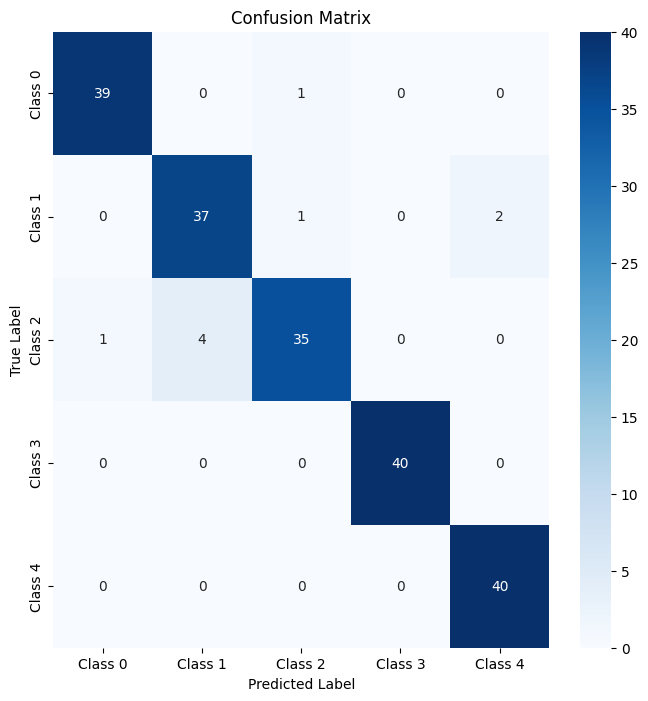

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the class labels (assuming they are 0, 1, 2, 3, 4)
class_labels = sorted(df['croplabel'].astype('int').unique())
class_names = [f"Class {label}" for label in class_labels] # Or map to actual crop names if you have that mapping

# Print the classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=class_names))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Saving the model

In [23]:
model.save('crop_classification_model.h5')
print("Model saved as crop_classification_model.h5")

Model saved as crop_classification_model.h5
